<a href="https://colab.research.google.com/github/pranshumalik14/intuitive-arm-reach/blob/main/notebooks/planar_n_dof_training_datagen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import re
from ast import literal_eval

## Input Data Cleaning

In [4]:
# read data
df = pd.read_csv('../training_data/sample_training_data_2D.csv')

In [5]:
from sys import platform

def str_to_floats(angle_str):
    angle_floats = angle_str[1:len(angle_str)-1].strip().split(" ")
    angle_floats = [angle for angle in angle_floats if angle != ""]
    angle_floats = [float(angle) for angle in angle_floats]
    return angle_floats

delimiter = "\r\n " if platform == "win64" else "\n "

# reshape x target
x_target = df['x_target']
x_target_np = x_target.to_numpy()
x_target = np.reshape(x_target_np, (x_target_np.shape[0], 1))

# rehsape y target
y_target = df['y_target']
y_target_np = y_target.to_numpy()
y_target = np.reshape(x_target_np, (y_target_np.shape[0], 1))

# reshape joint angles

joint_angles = df['init_joint_angles']
joint_angle_floats = []
for angles in joint_angles:
    joint_angle_floats.append(str_to_floats(angles))
joint_angle_np = np.array(joint_angle_floats)
joint_angles = joint_angle_np

# reshape theta

theta = df['Theta']
temp_theta = np.zeros(shape=(670, 5, 2)) #670 for each element, 2 for x & y, 5 for gaussian basis functions
for t in range(0, len(temp_theta)):
    if theta[t].startswith("[") and theta[t].endswith("]"):
        temp = theta[t][1:-1]
    else:
        print("Error")
    tp = temp.split("\n ")
    for i in range(0, len(tp)):
        temp_array = str_to_floats(tp[i])
        temp_theta[t][i] = temp_array
   
theta = temp_theta

print("Input sizes are: \n", "joint angles: ", str(joint_angles.shape), "\nx_target: ",
 str(x_target.shape), "\ny_target: ", str(y_target.shape))
print("Output size is:\n theta: ", str(theta.shape))

Input sizes are: 
 joint angles:  (670, 2) 
x_target:  (670, 1) 
y_target:  (670, 1)
Output size is:
 theta:  (670, 5, 2)


In [6]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

concat_input = np.zeros(shape=(x_target.shape[0], 4)) # joint angles, x_target, y_target
normalize_joint_angles = NormalizeData(joint_angles)
normalize_x_target = NormalizeData(x_target)
normalize_y_target = NormalizeData(y_target)

for i in range(0, len(concat_input)):
    concat_input[i][0] = normalize_joint_angles[i][0]
    concat_input[i][1] = normalize_joint_angles[i][1]
    concat_input[i][2] = normalize_x_target[i]
    concat_input[i][3] = normalize_y_target[i]
concat_input = NormalizeData(concat_input)

flatten_theta = np.zeros(shape=(theta.shape[0], theta.shape[1]*theta.shape[2]))
for i in range(0, len(flatten_theta)):
    flatten_theta[i] = theta[i].flatten()

## Model Creation

In [126]:
from ..src.rbf_petra.rbflayer import RBFLayer
from ..src.rbf_petra.random_initializer import InitCentersRandom
from ..src.rbf_petra.kmeans_initializer import InitCentersKMeans

from tensorflow import keras
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.losses import mean_squared_error, cosine_similarity

model = Sequential()
rbflayer = RBFLayer(10,
                      initializer=InitCentersRandom(concat_input),
                      betas=2.0,
                      input_shape=(4,))
model.add(rbflayer)
# model.add(Dense(80, activation='relu'))
# model.add(Dense(60, activation='relu'))
# model.add(Dense(40, activation='relu'))
model.add(Dense(10))
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=cosine_similarity)

## Train Model

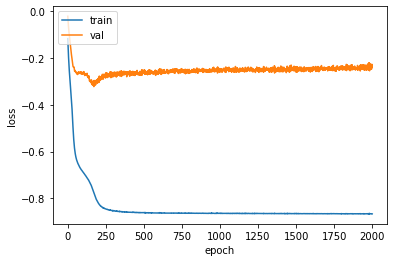

-0.8658811450004578


In [127]:
import matplotlib.pyplot as plt 
history = model.fit(concat_input, flatten_theta, batch_size=64, epochs=2000, verbose=0, validation_split=0.5)
# list all data in history
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# print(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print(history.history['loss'][-1])


In [138]:
to_predict = np.array([0.53, -2.44, 0.6, 0.0])
to_predict.shape 
to_predict = np.reshape(to_predict, (1, 4))
to_predict.shape 


(1, 4)

In [139]:
model.save("model1")
theta_predict = model.predict(to_predict)

INFO:tensorflow:Assets written to: model1/assets


In [140]:
print(theta_predict.shape)

(1, 10)


In [145]:
theta_reshaped = np.reshape(theta_predict, (5,2))
print(theta_predict)
print(theta_reshaped)

[[-0.09308792 -0.24803762 -0.05535848 -0.02591067 -0.02097575  0.01353363
  -0.01001174 -0.00500004 -0.04321717 -0.03067766]]
[[-0.09308792 -0.24803762]
 [-0.05535848 -0.02591067]
 [-0.02097575  0.01353363]
 [-0.01001174 -0.00500004]
 [-0.04321717 -0.03067766]]


## Model V2

In [63]:
import tensorflow as tf

In [75]:
# https://www.tensorflow.org/addons/tutorials/losses_triplet


In [3]:
# This training data is for the following robot
# robot_arm = rb.RobotArm2D(
#     n_dims = 3,
#     link_lengths=np.array([0.4, 0.5, 0.1])
# )

# TODO: probably export robot info in another CSV

In [4]:
df.dtypes

init_joint_angles     object
x_target             float64
y_target             float64
Theta                 object
iter_count             int64
cost                 float64
dtype: object

In [5]:
# Issue is that init_joint_angles and Theta are strings. (Check the CSV to understand more)
# It is imperative to first convert those strings into numpy arrays

In [6]:
df['init_joint_angles'].values[0]

'[ 0.53623095 -2.44887214]'

In [7]:
def extract_array_from_string(s):
    x = literal_eval(','.join(re.sub(r'(?<=\d)(\s+)(?=-?\d)', ',', s).splitlines()))
    return np.array(x)

In [8]:
df['init_joint_angles'] = df['init_joint_angles'].apply(extract_array_from_string)
df['Theta'] = df['Theta'].apply(extract_array_from_string)

In [9]:
print(type(df['init_joint_angles'].values[0]))
print(type(df['Theta'].values[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [10]:
df['Theta'].values[0]

array([[-3.48573555,  2.92546685],
       [-1.0769412 ,  0.71726378],
       [-0.09194794, -1.96637198],
       [-0.30857397, -1.11163421],
       [-0.64960408,  1.21820904]])

In [12]:
df.head(5)

,init_joint_angles,x_target,y_target,Theta,iter_count,cost
0,[ 0.53623095 -2.44887214],0.600000,0.000000,[[-3.48573555 2.92546685]\r\n [-1.0769412 0...,34,17.730630
1,[ 0.53623095 -2.44887214],0.459627,0.385673,[[-3.34089464 4.27195985]\r\n [-1.22788073 1...,15,0.053109
2,[ 0.53623095 -2.44887214],0.104189,0.590885,[[-4.13915419 4.76762425]\r\n [-2.04968351 2...,26,11.319121
3,[ 0.53623095 -2.44887214],-0.300000,0.519615,[[-5.03009515 5.05886301]\r\n [-2.98740589 2...,10,32.716189
4,[ 0.53623095 -2.44887214],-0.563816,0.205212,[[-5.60947522 6.06348489]\r\n [-4.42397733 2...,18,28.291913


## Data Descriptors
- Init joint angles: Joint configuration at time 0 of robot links
- x_target, y_target: desired target point on the plane for the end effector 
- Theta: output of the PIBB matrix (trained Theta)
- iter_count: (optional) number of iterations it took PIBB to reach to the final Theta
- Cost: (optional) cost function evaluated for this Theta 

Note: 
- this data is only for a specific 2D (planar) robot
- The last two params could be used for the interpolation algorithm (should prefer lower iter_count or cheaper cost)
